# Testing

Testing out DNE method, possibly along with others, to get a working version

_Had issues with PyTorch 2.5.0, so downgraded to 2.4.0_

So far, I've found a few interesting differences between what's found in the paper and the implementation, most likely in order to improve performance. Below is a highlight of how my method compares to their method:
1. __Vision Transformer__, The ViT seems to be the same as theirs, in terms of training but also in its output. I don't see any differences here in getting the embeddings.
2. __Method Transformation Differences__, this is really where they change things. They treat training and testing data differently, and regardless of what the argument args.strong_augmentation is set to, the method chosen changes the argument. So, when choosing their method, they automatically set strong augmentation to __True__, and when choosing another AD method they're comparing to, strong augmentation is set to __False__. What this does is set up their method to be trained on both normal and synthetic anomaly data, while other compared methods don't see the synthetic data at all. 
3. __Training/Testing Data Differences__, when getting training vs. testing data, training data does additional transformations: RandomRotation up to 90 degrees and a ColorJitter, which isn't present in the testing dataset transformations

In [1]:
import os
from pathlib import Path
import time

import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torchvision.utils import save_image
from torchvision import tv_tensors
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance
from torch.utils.data import DataLoader
import testing_utils as tu
from testing_utils.dne import *
from testing_utils.datasets import *

529 1058
['cable', 'leather', 'toothbrush']


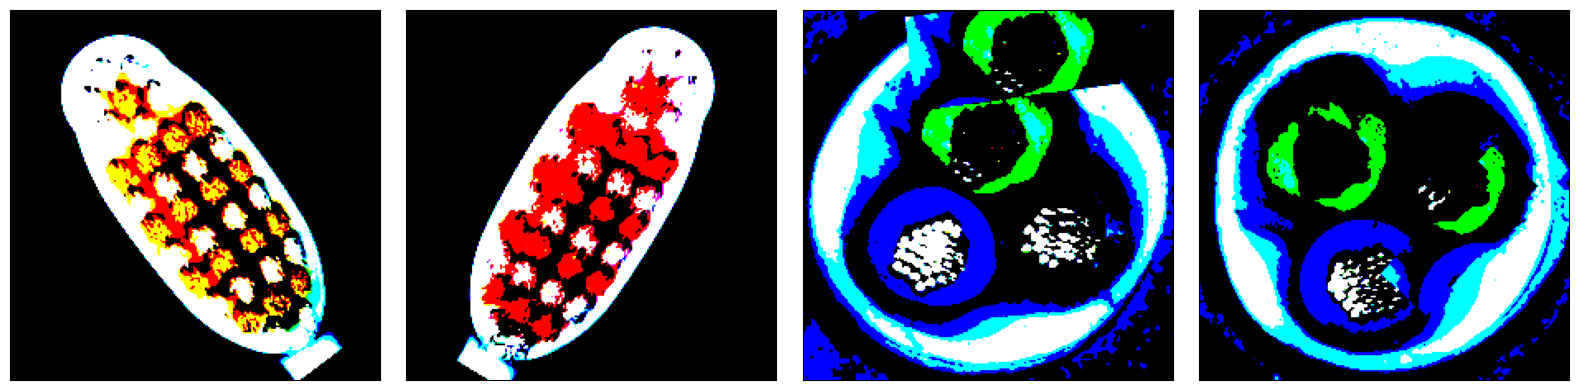

torch.Size([3, 224, 224])
[0, 0, 1, 1]


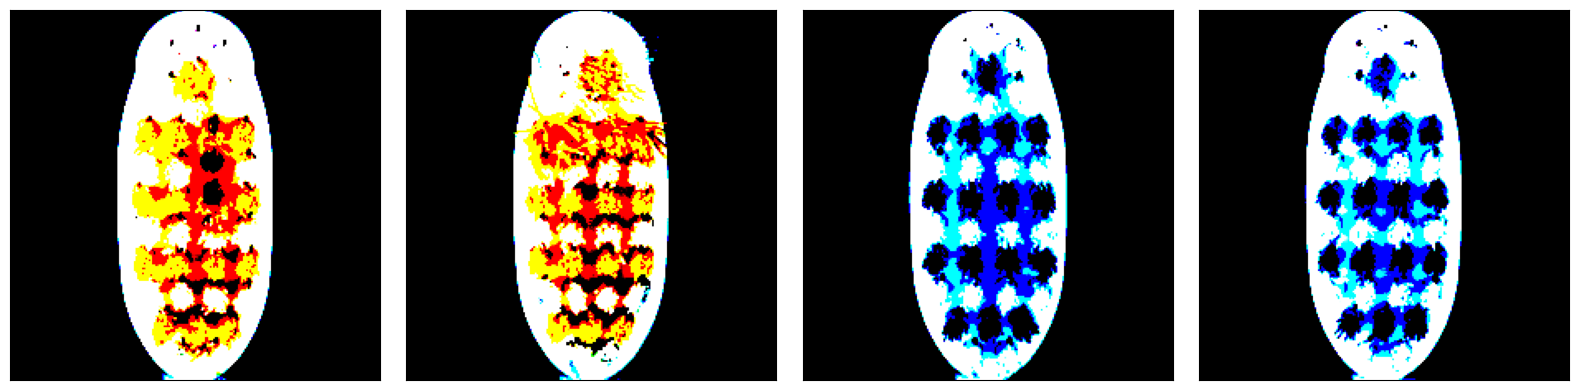

[1, 1, 0, 0]


In [2]:
task = 2
# Example training dataset
mvtec_mcil_train = mvtec(task=task, train=True)
img_save_path = Path('ex_files').resolve()
print(int(len(mvtec_mcil_train) / 2), len(mvtec_mcil_train))
print(mvtec_mcil_train.categories)
data = []
labels = []
for i in range(527, 531):
    img = mvtec_mcil_train[i][0]
    save_image(img, img_save_path / f'train_{i}.png')
    data.append(img * 255)
    labels.append(mvtec_mcil_train[i][1])
tu.show(data)
print(mvtec_mcil_train[0][0].shape)
print(labels)

# Example test dataset
mvtec_mcil_test = mvtec(task=task, train=False)
data = []
labels = []
s = 302
for i in range(s, s + 4):
    img = mvtec_mcil_test[i][0]
    save_image(img, img_save_path / f'test_{i}.png')
    data.append(img * 255)
    labels.append(mvtec_mcil_test[i][1])
tu.show(data)
print(labels)

In [8]:
# Params, based on paper, and if not there, in code (configs)
TRAIN = True
num_epochs = 50
batch_size = 32
weight_decay = 0.00003
lr = 0.0003
alpha = 0.4
checkpoint_path = Path('checkpoints/our_implementation').resolve()

In [ ]:
if TRAIN:
    model = DNE()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    model.train()
    total_train_time = 0
    for t in range(1, 6):  # task, t
        """
        Training
        - 1 epoch takes ~ 60 seconds to train, so 60 sec * 50 epochs ~ 50 minutes per task
        - If there are 5 tasks, then training time for all tasks 
        for one experiment would be ~ 4 hours 10 minutes
        """
        print(f'---Task {t}/5---')
        # Train classifier head only on first task
        if t == 1:
            model.freeze_head(False)
            print('Head Classifier: NOT Frozen')
        else:
            model.freeze_head(True)
            print('Head Classifier: Frozen')

        # Create dataset
        train_data = mvtec(multi=True, mtd=False, train=True, task=t)
        train_dataloader = DataLoader(train_data,
                                      batch_size=batch_size,
                                      shuffle=True)
        print('Train Data Length:', len(train_data))
        print()
        num_batches = len(train_dataloader)
        task_train_time = 0
        task_num_correct = 0

        for e in range(num_epochs):
            # Each epoch seems to run quickly, so we will calculate time and loss per epoch
            start = time.time()
            epoch_loss = 0

            # Only update z-epoch at final epoch
            update_z_epoch = True if ((e + 1) == num_epochs) else False

            # Iterate through each batch
            for batch_idx, (imgs, labels, category) in enumerate(train_dataloader):
                # print(imgs.shape)
                # print(labels.shape)
                # print(category)
                optimizer.zero_grad()
                imgs = imgs.to(model.device)
                outputs = model(imgs, head=True,
                                add_to_z_epoch=update_z_epoch).cpu()
                if e + 1 == num_epochs:
                    task_num_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
                loss = criterion(outputs, labels)
                loss.backward()
                epoch_loss += loss.item()
                optimizer.step()

            end = time.time()
            epoch_time = end - start
            task_train_time += epoch_time
            if (e + 1) % 10 == 0:
                print('Epoch {}/{}'.format(e + 1, num_epochs))
                if update_z_epoch:
                    print('Updated Z Epoch')
                print('Epoch time: {:.1f} seconds'.format(epoch_time))
                print('Epoch loss: {:.5f}'.format(epoch_loss))
                print()

        # Updates the memory, M, with statistics from current task after epoch 50
        model.update_memory()

        task_train_time /= 60  # puts total task train time in minutes
        print(f'Task Training Time: {task_train_time:.2f} minutes')
        print(f'Task Accuracy on epoch 50: {round(task_num_correct / len(train_data), 3)}')
        print()
        total_train_time += task_train_time

        # Save model_dict for this task
        pt_name = 'model'
        for j in time.localtime()[0:5]: pt_name += f'_{j}'
        pt_name += f"_task_{t}.pt"
        torch.save(model.state_dict(), checkpoint_path / pt_name)

    print(f'Total Experiment Training Time: {total_train_time / 60:.2f} hours')
    # TODO: Save model info
    z_global = model.generate_global_samples().cpu()

Using cuda device
---Task 1/5---
Head Classifier: NOT Frozen
Train Data Length: 1660



In [7]:
"""
Testing
- Paper shows accuracies, but I'm not sure how that would work
- You can only compute anomaly scores using Mahalanobis distance after training all tasks,
    as it requires the global distribution across all tasks
- Even then, they don't show any threshold for Mahalanobis distance in paper
- For now, we will look at accuracy of model based on head output
- This point of testing is to mimic figure 3, where we show avg. accuracy of past tasks
"""
if not TRAIN:
    model = DNE()
    pt_name = os.listdir('checkpoints/our_implementation')[0]
    latest_state_dict = torch.load(checkpoint_path / pt_name)
    model.load_state_dict(latest_state_dict)
    z_global = model.generate_global_samples().cpu()

# TODO: Look for Mahalanobis distance threshold in code for anomaly data
# Now, we want to calculate our global distribution
# self.z_global should have a size N x 768
# where N = number of samples from all tasks
# CAD code has an alpha parameter = 0.4, and alpha in paper is the shrinkage
cov_shrunk = ShrunkCovariance(store_precision=True, shrinkage=0.4)
cov_shrunk.fit(z_global.numpy())

model.eval()
total_test_time = 0
distance_scores = None
all_labels = None
avg_test_accuracy = []
for t in range(1, 6):  # task, t
    print(f'---Task {t}/5---')

    # Create dataset
    test_data = mvtec(multi=True, mtd=False, train=False, task=t)
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=True)
    num_batches = len(test_dataloader)
    task_test_time = 0

    start = time.time()
    task_num_correct = 0

    with torch.no_grad():
        # Iterate through each batch
        for batch_idx, (imgs, labels, category) in enumerate(test_dataloader):
            # print(imgs.shape)
            # print(labels.shape)
            # print(category)
            imgs = imgs.to(model.device)
            outputs = model(imgs, head=True,
                            add_to_z_epoch=False).cpu()
            task_num_correct += sum(torch.argmax(outputs, dim=1) == labels).item()
            embeds = model.embed(imgs).cpu()
            if distance_scores is None:
                distance_scores = cov_shrunk.mahalanobis(embeds)
                all_labels = labels.cpu().numpy()
            else:
                distance_scores = np.concatenate((distance_scores,
                                                  cov_shrunk.mahalanobis(embeds)))
                all_labels = np.concatenate((all_labels,
                                             labels.cpu().numpy()))

    end = time.time()
    task_test_time = end - start
    total_test_time += task_test_time
    task_test_accuracy = task_num_correct / len(test_data)
    avg_test_accuracy.append(task_test_accuracy)
    print('Task time: {:.1f} seconds'.format(task_test_time))
    print('Task Accuracy: {:.3f}'.format(task_test_accuracy))
    print()

total_test_time /= 60  # puts total task test time in minutes
print(f'Total Test Time: {total_test_time:.2f} minutes')
print(f'Average Test Accuracy: {np.mean(avg_test_accuracy):.3f}')
print()

Using cuda device


C:\Users\chadw\AppData\Local\Temp\ipykernel_18012\55450560.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latest_state_dict = torch.load(checkpoint_path / pt_name)


AttributeError: 'NoneType' object has no attribute 'cpu'

In [6]:
# plt.style.use('seaborn')
plt.figure(figsize=(12, 6))
for label in np.unique(all_labels):
    mask = (all_labels == label)
    print(label, len(distance_scores[mask]))
    plt.hist(distance_scores[mask], alpha=0.5, label='Anomaly' if label == 1 else 'Normal',
             bins=100, density=True)

plt.xlabel('Distance Scores')
plt.ylabel('Density')
plt.title('Distribution of Mahalanobis Distance by Label')
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()


NameError: name 'all_labels' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024 ** 2
print('model size: {:.2f} MB'.format(size_all_mb))

In [16]:
model.eval()
test_data = mvtec(multi=True, mtd=False, train=False, task=t)
with torch.no_grad():
    output = model(test_data[0][0].to(model.device), head=True).cpu()
output

tensor([[ 6.2107, -6.1812]])

In [18]:
torch.argmax(output, dim=1)

tensor([0])

In [25]:
F.softmax(output, dim=0)

tensor([[1., 1.]])

In [28]:
F.softmax(outputs)

C:\Users\chadw\AppData\Local\Temp\ipykernel_5384\4291817640.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(outputs)


tensor([[6.5673e-05, 9.9993e-01],
        [4.3407e-06, 1.0000e+00],
        [1.0000e+00, 4.7735e-06],
        [9.9999e-01, 6.4537e-06],
        [9.9999e-01, 7.9992e-06],
        [9.9999e-01, 7.8065e-06],
        [1.0000e+00, 3.6937e-06],
        [9.9999e-01, 5.4615e-06],
        [1.0000e+00, 4.7680e-06],
        [4.5507e-06, 1.0000e+00],
        [9.9999e-01, 8.5447e-06],
        [5.8159e-05, 9.9994e-01],
        [5.8177e-05, 9.9994e-01],
        [1.6058e-05, 9.9998e-01],
        [4.1709e-06, 1.0000e+00],
        [4.2698e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [45]:
test_data = mvtec(multi=True, mtd=False, train=False, task=1)

In [43]:
labels

tensor([1, 0, 1, 1, 1])

In [44]:
outputs

tensor([[ 6.1642, -6.1315],
        [ 6.1574, -6.1217],
        [ 5.8539, -5.8029],
        [ 6.1489, -6.1109],
        [ 6.1506, -6.1136]])

In [41]:
F.softmax(outputs)

C:\Users\chadw\AppData\Local\Temp\ipykernel_5384\4291817640.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(outputs)


tensor([[1.0000e+00, 4.5713e-06],
        [1.0000e+00, 4.6476e-06],
        [9.9999e-01, 8.6601e-06],
        [1.0000e+00, 4.7386e-06],
        [1.0000e+00, 4.7175e-06]])